# Stacking

- Split the data
- Train several models on your training dataset
- Trained models become feature rows with prediction(s)
- A new training set is created from the model predictions
- Features are then used by the `Meta Model` after it is trained
- Then the final predictions are made

![screenshot](<attachment:Screen Shot 2024-03-13 at 7.21.38 PM.png>)
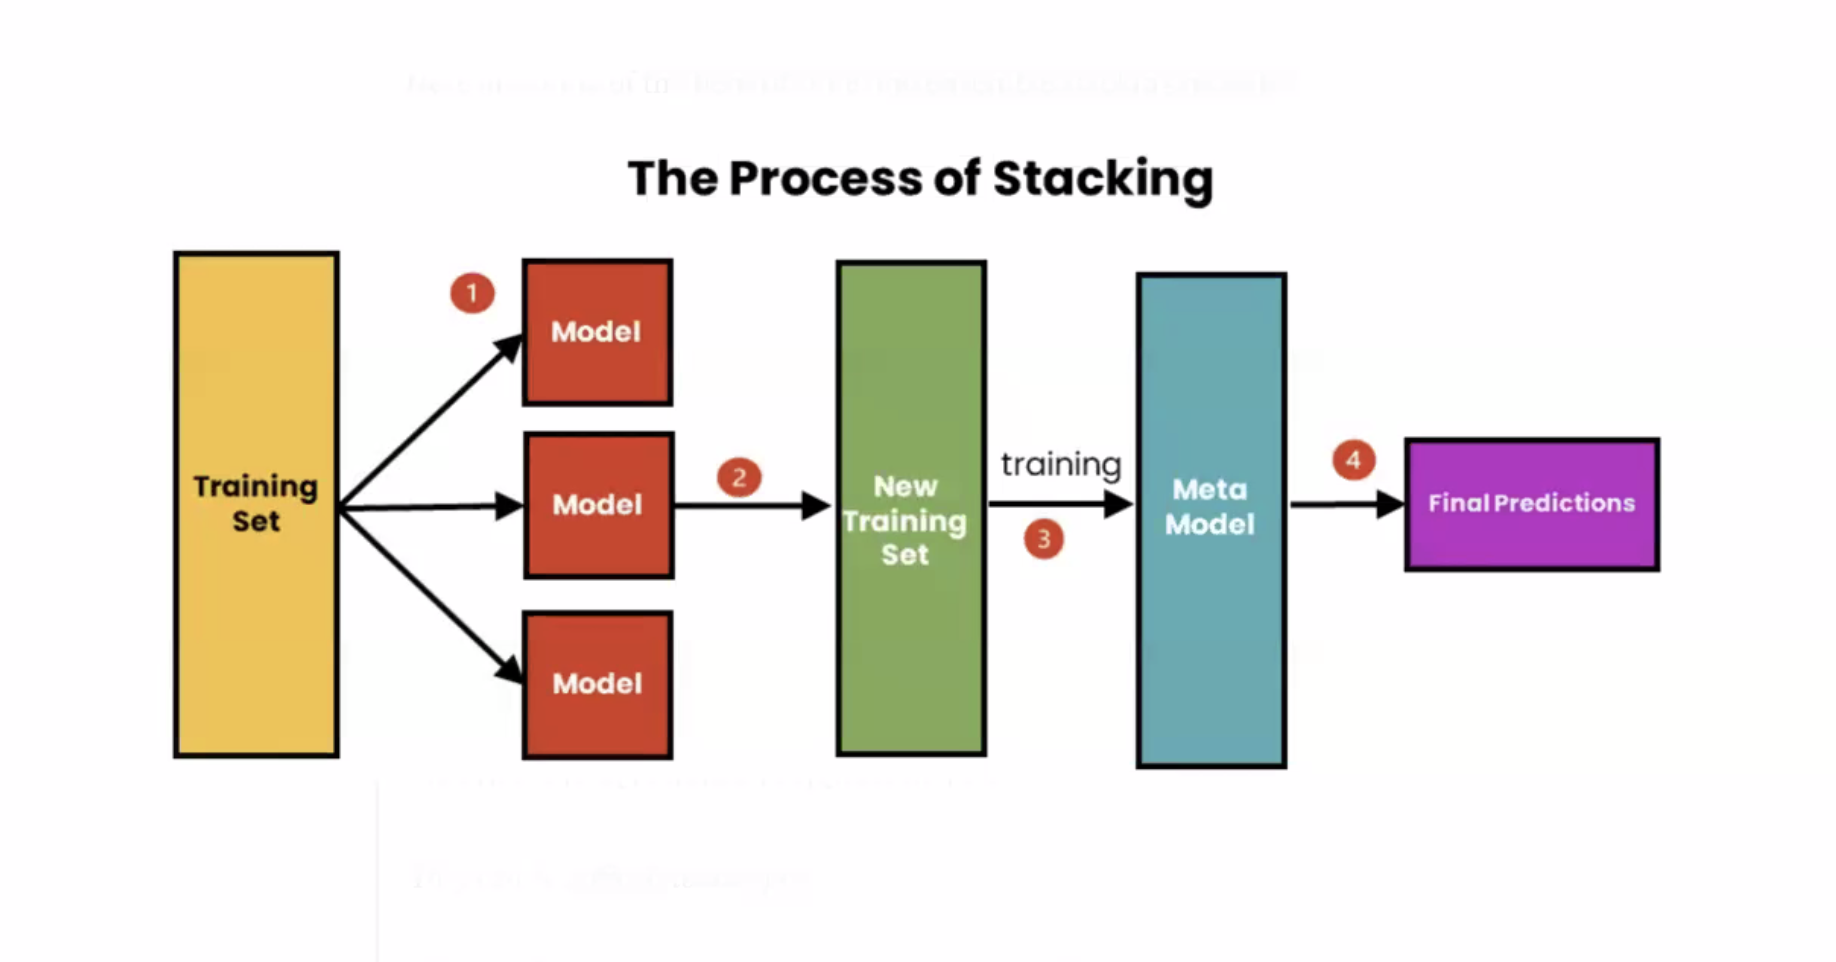

In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Base learners/models: RandomForest, SVM, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier # ensemble bagging algo
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Meta model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

from scikeras.wrappers import KerasClassifier
# from scikeras.wrappers import KerasRegressor (regression problems)

2024-03-13 21:26:01.201547: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
X, y = make_moons(n_samples=600, noise=.3, random_state=40)

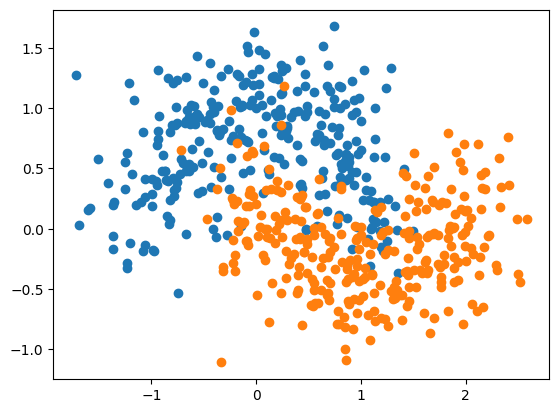

In [3]:
plt.scatter(x=X[y == 0][:, 0], y=X[y == 0][:, 1])
plt.scatter(x=X[y == 1][:, 0], y=X[y == 1][:, 1])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=40)

## Base Models

In [5]:
# Define base model classifiers
log_reg = LogisticRegression(solver='lbfgs', random_state=40)
rnd_for = RandomForestClassifier(n_estimators=100, random_state=40)
svm_cl = SVC(gamma='scale', random_state=40, probability=True)

# Alternative libraries for above classifiers
# tf.keras.RandomForestModel
# tf.keras.GradientBoostedTreesModel

# There are also linear classification models in keras/tf

### Define Meta Model using NN

In [6]:
# Package NN steps into a function
def build_nn():
    model = Sequential(
        [
            Dense(60, activation="relu", input_shape=[2]),
            Dense(1, activation="sigmoid"),
        ]
    )
    model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [7]:
keras_nn = KerasClassifier(build_nn, epochs=400)

# Classification model indication
keras_nn._estimator_type = 'classifier'

`scikeras.wrappers` builds a bridge between SK Learn and Keras/TensorFlow. It allows the user to deploy Keras/TF models as an SKLearn estimator (easy integration between Keras and SKLearn).

### Assemble Models with Voting Mechanism

In [8]:
voter = VotingClassifier(
    estimators=[("lr", log_reg), ("rf", rnd_for), ("svc", svm_cl), ("keras", keras_nn)],
    # estimators=[log_reg, rnd_for, svm_cl, keras_nn],
    voting="soft",
    flatten_transform=True,
)

**Voting Params**
- `soft` voting means applying an activation functino (argmax) on the sum of the predicted probabilities (always recommended). Helps with indecisiveness in the voting.
- `hard` voting means choosing the majority rule voting

In [9]:
# Train the model
voter.fit(X_train, y_train)

Epoch 1/400


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5300 - loss: 0.6848  
Epoch 2/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - accuracy: 0.8178 - loss: 0.6330
Epoch 3/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.8300 - loss: 0.5868
Epoch 4/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.8097 - loss: 0.5601
Epoch 5/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - accuracy: 0.8624 - loss: 0.5042
Epoch 6/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.8613 - loss: 0.4784
Epoch 7/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.8437 - loss: 0.4591
Epoch 8/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - accuracy: 0.8185 - loss: 0.4562
Epoch 9/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - accuracy: 0.8636 - loss: 0.4086
Epoch 10/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - accuracy: 0.8644 - loss: 0.4066
Epoch 11/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.8540 - loss: 0.4000
Epoch 12/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step

ValueError: Could not interpret metric identifier: loss

### Evaluation

Let's evaluate the performance of 1 model running by itself vs. the stacked model

In [ ]:
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
accuracy_score(y_test, y_pred)

NameError: name 'log_reg' is not defined

In [ ]:
for model in [log_reg, rnd_for, svm_cl, keras_nn, voter]:
  model.fit(X_train, y_train)
  y_pred = log_reg.predict(X_test)
  accuracy_score(y_test, y_pred)
  print(accuracy_score)

<function accuracy_score at 0x13d24bec0>
<function accuracy_score at 0x13d24bec0>
<function accuracy_score at 0x13d24bec0>


TypeError: TargetReshaper.transform() takes 1 positional argument but 2 were given